# [Risk Analysis 2020-2025] The "Mag 7" & TSLA vs AVGO

**Objective:** Analyze the internal correlation and risk structure of the "Mag 7" stocks

**Methodology:**
*   **Rolling Correlation:** To detect decoupling.
*   **Risk Contribution:** To quantify volatility concentration.
*   **CVaR (95%):** To measure tail risk.
*   **Backtest:** To test a TSLA alternative (AVGO).

---



In [1]:
!pip install -q yfinance plotly PyPortfolioOpt

import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly Template
import plotly.io as pio
pio.templates.default = "plotly_white"

print("Libraries loaded.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 10.5 MB/s eta 0:00:00
Libraries loaded.


## 1. Data
*   **Tickers:** AAPL, MSFT, GOOGL, AMZN, NVDA, META, TSLA.
*   **Benchmark:** SPY (S&P 500).
*   **Challenger:** AVGO (Broadcom).
*   **Range:** 2020-Present (Daily Adjusted Close).



In [2]:
# Define Tickers
mag7_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA']
benchmark = 'SPY'
alternate = 'AVGO' # Broadcom

all_tickers = mag7_tickers + [benchmark, alternate]
# List for Analysis Charts (Mag7 + AVGO)
analysis_tickers = mag7_tickers + [alternate]

# Download Data
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Downloading data from {start_date} to {end_date}...")
raw_data = yf.download(all_tickers, start=start_date, end=end_date)

# Data Cleaning & Fallback Logic
try:
    data = raw_data['Adj Close']
except KeyError:
    print("'Adj Close' not found. Using 'Close'...")
    data = raw_data['Close']

# Fill missing values
if data.isnull().values.any():
    data = data.ffill().dropna()

print(f"Data successfully loaded: {data.shape[0]} days.")

# Calculate Log Returns
log_returns = np.log(data / data.shift(1)).dropna()

# Comparison Chart (Rebased to 100)
rebased_prices = (data[analysis_tickers] / data[analysis_tickers].iloc[0]) * 100

fig = px.line(rebased_prices, x=rebased_prices.index, y=analysis_tickers,
              title='Performance Divergence (Base 100)',
              labels={'value': 'Value ($)', 'variable': 'Ticker'})
# Highlight AVGO line
fig.update_traces(patch={"line": {"dash": "dot", "width": 3}}, selector={"name": "AVGO"})
fig.update_layout(hovermode="x unified")
fig.show()



/tmp/ipython-input-4167697038.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(all_tickers, start=start_date, end=end_date)
[*********************100%***********************]  9 of 9 completed


'Adj Close' not found. Using 'Close'...
Data successfully loaded: 1509 days.


## 2. Evidence of Correlation Breakup
We ran a **6-Month Rolling Correlation** vs SPY.
*   Look at **TSLA (Pink line)**. It frequently drops below 0.3, behaving like a random outlier.
*   **AVGO (Green Dotted line)** tracks the market consistently (>0.6).



In [3]:
# Calculate Rolling Correlation (Window = 126 days, approx 6 months)
window = 126
rolling_corr = log_returns[analysis_tickers].rolling(window=window).corr(log_returns['SPY'])
rolling_corr = rolling_corr.dropna()

# Visualize
fig = go.Figure()

for ticker in analysis_tickers:
    # Highlight Tiers
    if ticker == 'TSLA':
        width = 4
        opacity = 1.0
        line_dash = 'solid'
        color = '#EF553B' # Red/Pink
    elif ticker == 'AVGO':
        width = 4
        opacity = 1.0
        line_dash = 'dot' # Distinguish AVGO
        color = '#00CC96' # Green
    else:
        width = 1.5
        opacity = 0.3
        line_dash = 'solid'
        color = None

    fig.add_trace(go.Scatter(
        x=rolling_corr.index,
        y=rolling_corr[ticker],
        mode='lines',
        name=ticker,
        line=dict(width=width, dash=line_dash, color=color),
        opacity=opacity
    ))

fig.update_layout(
    title='Rolling Correlation: TSLA vs AVGO',
    yaxis_title='Correlation Coefficient',
    hovermode='x unified'
)
fig.show()



### Internal Correlation Heatmap (Last 12 Months)



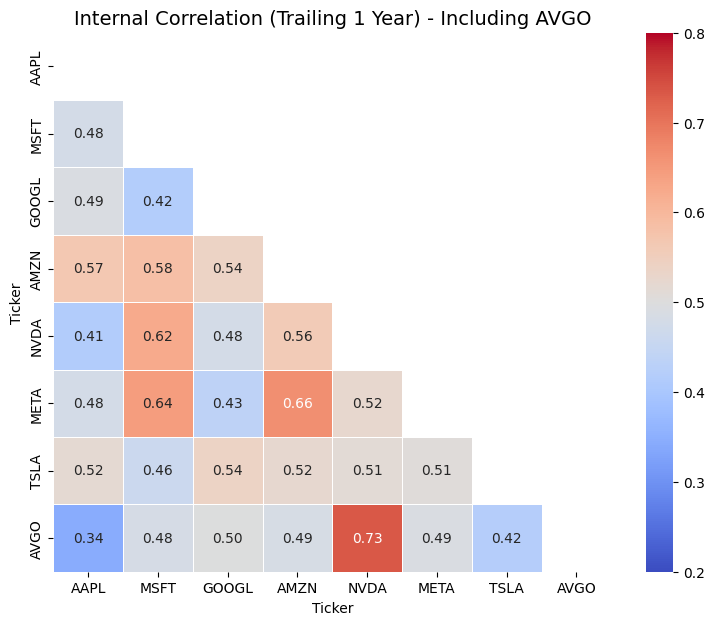

In [4]:
# Correlation of the last 1 year only
recent_corr = log_returns[analysis_tickers].iloc[-252:].corr()
mask = np.triu(np.ones_like(recent_corr, dtype=bool))

plt.figure(figsize=(9, 7))
sns.heatmap(recent_corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=0.2, vmax=0.8, linewidths=0.5)
plt.title('Internal Correlation (Trailing 1 Year) - Including AVGO', fontsize=14)
plt.show()



## 3. Risk Analysis

*   **TSLA** contributes contributes **>20%** of total portfolio volatility, significantly more than **AVGO**.
*   **MSFT/AAPL** contribute **<12%**.
*   **AVGO** sits in the middle

*Holding TSLA equal-weight is inefficient: You pay "High Volatility" prices but aren't getting the correlation benefit.*

In [5]:
# Function: Marginal Risk Contribution
def calculate_risk_contribution(weights, cov_matrix):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    mrc = np.dot(cov_matrix, weights) / port_vol
    rc = weights * mrc
    return rc, port_vol

# Assume Equal Weights (1/8 now)
weights = np.array([1/len(analysis_tickers)] * len(analysis_tickers))
cov_matrix = log_returns[analysis_tickers].cov() * 252 # Annualized

risk_contrib, port_vol = calculate_risk_contribution(weights, cov_matrix)
risk_contrib_pct = risk_contrib / port_vol

# Visualize
rc_df = pd.DataFrame({'Ticker': analysis_tickers, 'Risk Contribution': risk_contrib_pct})
rc_df = rc_df.sort_values(by='Risk Contribution', ascending=False)

# Custom Colors
colors = ['#EF553B' if x == 'TSLA' else '#00CC96' if x == 'AVGO' else '#636EFA' for x in rc_df['Ticker']]

fig = px.bar(rc_df, x='Ticker', y='Risk Contribution',
             title='Risk Contribution (8-Stock Equal Weight)',
             color='Ticker', color_discrete_map={'TSLA': '#EF553B', 'AVGO': '#00CC96'})
fig.update_traces(marker_color=colors, showlegend=False)
fig.add_hline(y=1/len(analysis_tickers), line_dash="dash", line_color="black", annotation_text="Equal Target")
fig.update_layout(yaxis_tickformat='.1%')
fig.show()



### Tail Risk (CVaR 95%)
* In the worst 5% of days, **TSLA** loses nearly **2x** as much as **MSFT**.
* **AVGO** has a tail risk profile comparable to NVDA/META, safer than TSLA.



In [6]:
def calculate_cvar(returns, confidence_level=0.05):
    sorted_returns = returns.sort_values()
    index = int(confidence_level * len(sorted_returns))
    cvar = sorted_returns.iloc[:index].mean()
    return cvar

cvar_results = {t: calculate_cvar(log_returns[t]) for t in analysis_tickers}
cvar_df = pd.Series(cvar_results).sort_values()

# Color logic
colors = ['#EF553B' if x == 'TSLA' else '#00CC96' if x == 'AVGO' else 'lightgrey' for x in cvar_df.index]

fig = px.bar(x=cvar_df.index, y=cvar_df.values,
             title='CVaR (95%): Average Crash Day Loss',
             labels={'y': 'Daily Loss (%)', 'x': 'Ticker'})
fig.update_traces(marker_color=colors)
fig.update_layout(yaxis_tickformat='.1%')
fig.show()



## 4. Swapping TSLA for AVGO (Broadcom)

**Backtest (2020-Present):**
*   **Blue Line:** Classic Mag 7.
*   **Red Line:** Modified (Remove TSLA, Add AVGO).



In [7]:
# Define Portfolios
tickers_classic = mag7_tickers
tickers_optimized = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'AVGO']

# Backtest Period
backtest_start = '2020-01-01'
bt_returns = log_returns.loc[backtest_start:]

# Calculate Daily Portfolio Returns (Equal Weight)
port_classic_ret = bt_returns[tickers_classic].mean(axis=1)
port_optimized_ret = bt_returns[tickers_optimized].mean(axis=1)
spy_ret = bt_returns['SPY']

comparison = pd.DataFrame({
    'Mag 7 (Classic)': port_classic_ret,
    'Mag 7 (Modified: +AVGO -TSLA)': port_optimized_ret,
    'S&P 500': spy_ret
})

# Cumulative Returns
cum_returns = (1 + comparison).cumprod()

fig = px.line(cum_returns, title=f'Backtest: Classic vs Modified (Since {backtest_start})')
fig.show()



### Results
*   **Higher Sharpe** (More return per unit of risk).
*   **Way Lower Drawdown**


In [8]:
rf_rate = 0.04 # 4% Risk Free Rate assumption

def get_metrics_table(returns_df):
    metrics = []
    for col in returns_df.columns:
        r = returns_df[col]
        ann_ret = r.mean() * 252
        ann_vol = r.std() * np.sqrt(252)
        sharpe = (ann_ret - rf_rate) / ann_vol

        # Calculate Max Drawdown
        cum = (1 + r).cumprod()
        peak = cum.cummax()
        dd = (cum - peak) / peak
        max_dd = dd.min()

        metrics.append([col, ann_ret, ann_vol, sharpe, max_dd])

    return pd.DataFrame(metrics, columns=['Portfolio', 'Ann. Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])

metrics_df = get_metrics_table(comparison)
# Style the table
metrics_df.style.format({
    'Ann. Return': '{:.1%}',
    'Volatility': '{:.1%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.1%}'
}).background_gradient(subset=['Sharpe Ratio'], cmap='Greens').background_gradient(subset=['Max Drawdown'], cmap='Reds_r')



,Portfolio,Ann. Return,Volatility,Sharpe Ratio,Max Drawdown
0,Mag 7 (Classic),29.1%,32.7%,0.77,-56.3%
1,Mag 7 (Modified: +AVGO -TSLA),28.6%,31.2%,0.79,-51.1%
2,S&P 500,13.9%,20.8%,0.48,-35.7%


## 5. Optimized Allocation (Minimum Volatility)
**Charts:**

We calculate the Efficient Frontier to find the **Minimum Volatility** weighting.
*   **Hypothesis:** If TSLA is risky, a "Safety" algorithm should treat it like garbage and remove it from the portfolio.
*   **Expectation:** High weights for stable compounders (MSFT, AAPL, AMZN) and potentially AVGO.

*   **Note:** We utilize **L2 Regularization**. Without it, a standard optimizer often allocates 100% to the top winner (NVDA). Regularization forces a "Diversified" solution, which is more realistic for portfolio construction.



In [9]:
# Define Portfolios (Optimizing on the "Modified" Basket idea + classic components)
tickers_to_optimize = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AVGO']

# Backtest Period
backtest_start = '2020-01-01'
bt_data = data[tickers_to_optimize].loc[backtest_start:]

# 1. Calculate Risk Model
S = risk_models.sample_cov(bt_data)
# We don't even need Expected Returns for Min Volatility! Pure risk management.

# 2. Optimize for Minimum Volatility
ef = EfficientFrontier(None, S) # Returns not needed for Min Vol
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # Slight regularization to avoid 100% in one stock
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

print("Optimized Weights (Min Volatility):")
print(cleaned_weights)

# Visualize Weights
opt_df = pd.DataFrame(list(cleaned_weights.items()), columns=['Ticker', 'Optimized Weight'])
opt_df = opt_df[opt_df['Optimized Weight'] > 0.001]
opt_df = opt_df.sort_values(by='Optimized Weight', ascending=False)

fig = px.pie(opt_df, values='Optimized Weight', names='Ticker',
             title='Mathematically Safest Allocation (Min Volatility)',
             hole=0.4)
fig.update_traces(textinfo='percent+label')
fig.show()

# 3. Quick Backtest of the "Safe" Portfolio vs SPY
opt_weights_list = [cleaned_weights.get(t, 0) for t in tickers_to_optimize]
# Calculate daily returns of the safe portfolio
safe_daily_ret = log_returns[tickers_to_optimize].loc[backtest_start:].dot(opt_weights_list)

# Compare Volatility
safe_vol = safe_daily_ret.std() * np.sqrt(252)
spy_vol = log_returns['SPY'].loc[backtest_start:].std() * np.sqrt(252)

print(f"Safe Portfolio Volatility: {safe_vol:.1%}")
print(f"S&P 500 Volatility: {spy_vol:.1%}")



Optimized Weights (Min Volatility):
OrderedDict({'AAPL': 0.22604, 'MSFT': 0.23879, 'GOOGL': 0.20615, 'AMZN': 0.16294, 'NVDA': 0.0, 'META': 0.06317, 'TSLA': 0.0, 'AVGO': 0.1029})


Safe Portfolio Volatility: 28.1%
S&P 500 Volatility: 20.8%


## 6. Conclusion

*   **Risk:** TSLA is a statistical outlier. In Rolling Correlation, it behaves like an uncorrelated asset, but contributes **>20%** of the risk.
*   **Stability:** **Broadcom (AVGO)** tracks the Tech Beta much more reliably (Green Dotted Line).
*   **Optimization:** Optimizing for **Min Volatility** drastically cuts TSLA and allocates to stable infrastructure pillars.

*For full disclosure, this document and the source code are my original work, with assistance from Gemini 3 Pro in formatting and correcting Markdown, and resolving code bugs.*
